Author: Zhewei Yao <https://github.com/yaozhewei>, Amir Gholami <http://amirgholami.org/>_


This tutorial shows how to use AdaHessian https://github.com/amirgholami/adahessian, for machine learning problems, and also analyze AdaHessian for a simple 2D problem using the repo https://github.com/githubharald/analyze_ada_hessian

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from adahessian import AdaHessian
from plot import plot_path, plot_function, show_plot, oneD_plot
from track_trace import track_trace

In [2]:
def make_func(s):
    "parse the passed function string"
    def func(v):
        return eval(s)
    return func

In [3]:
class parser():
    def __init__(self):
        self.func = None
        self.num_iter = 10 
        self.start = (1., 1.)
        self.window = (-2., 2., -2., 2.)
        self.lr = 0.1 
        self.beta_g = 0.5
        self.beta_h = 0.5 
        self.hessian_pow = 1.
        

## Example1:

Let's first start with a simple quadratic function of the form: 

$$f(x, y) = x^2 + 5y^2$$

We will use adahessian to optimize this function.

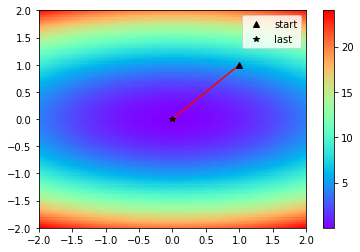

In [4]:
parsed = parser()

parsed.func = "v[0]**2+5*v[1]**2"
parsed.lr = 1.
parsed.beta_g = 0
parsed.beta_h = 0


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = track_trace(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


## Example 2:

Let's now make the function slightly more interesting by adding a cross term:
$$f(x, y) = x^2 + 5y^2 + xy$$

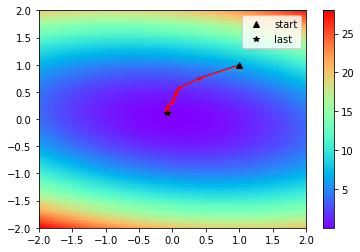

In [5]:
parsed = parser()

parsed.func = "v[0]**2+5*v[1]**2+v[0]*v[1]"
parsed.lr = .2
parsed.beta_g = 0.
parsed.beta_h = 0.


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = track_trace(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()


## Example 3.1:

Now let's add some sinusoidal noise of the form:
$$f(x, y) = x^2 + 5y^2 + xy + \frac{1}{2}sin(5*x)^2 + \frac{1}{2}sin(5*y)^2$$

Let's also turn off the momentum for both gradient and Hessian and see the results.
We will then compare the convergence by turning on the gradient momentum (exmaple 3.2) and Hessian momentum (example 3.3). The goal is to show the importance of momentum.

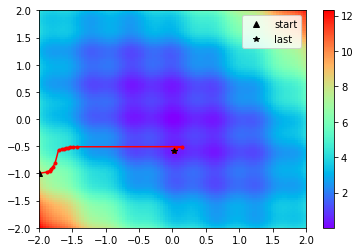

Current loss value is: 0.3588


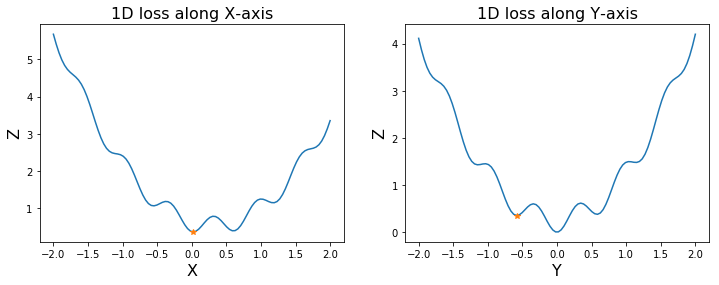

In [6]:
parsed = parser()

# without momentum
parsed.func = "v[0]**2+v[1]**2+v[0]*v[1]+0.5*torch.sum(torch.sin(5*v)**2)"
parsed.lr = 0.2
parsed.start = (-2, -1)
parsed.num_iter = 50
parsed.beta_g = 0.
parsed.beta_h = 0.


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = track_trace(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()

# 1D plot 
x, y = path[-1]
oneD_plot(x, y, func)




## Example 3.2:

Now let's repeat the above experiment by turning on gradient momentum (with Hessian momentum still turned off).


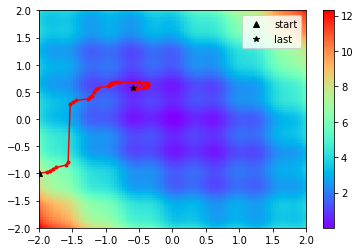

Current loss value is: 0.3929


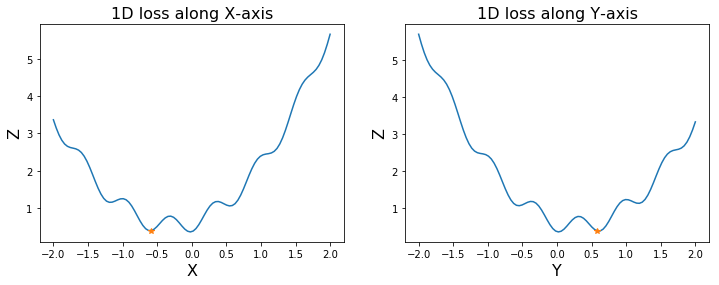

In [7]:
parsed = parser()

# with only gradient momentum
parsed.func = "v[0]**2+v[1]**2+v[0]*v[1]+0.5*torch.sum(torch.sin(5*v)**2)"
parsed.lr = 0.2
parsed.start = (-2, -1)
parsed.num_iter = 50
parsed.beta_g = 0.9
parsed.beta_h = 0.


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = track_trace(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()

# 1D plot 
x, y = path[-1]
oneD_plot(x, y, func)

## Example 3.3:

Now let's repeat the above experiment by turning on Hessian momentum as well.



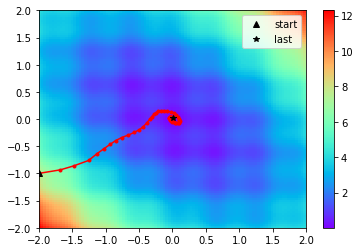

Current loss value is: 0.0042


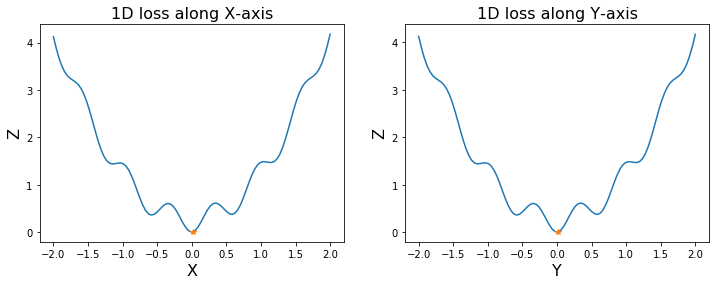

In [8]:
parsed = parser()

# with both first/second momentum
parsed.func = "v[0]**2+v[1]**2+v[0]*v[1]+0.5*torch.sum(torch.sin(5*v)**2)"
parsed.lr = .5
parsed.start = (-2, -1)
parsed.num_iter = 50
parsed.beta_g = 0.9
parsed.beta_h = 0.9


func = make_func(parsed.func)

# optimize 2d parameter vector v of function
path = track_trace(func, parsed.start, parsed.num_iter, parsed.lr, parsed.beta_g, parsed.beta_h, parsed.hessian_pow)

# plot function and steps of optimizer
plot_function(func, parsed.window)
plot_path(path)
show_plot()

# 1D plot 
x, y = path[-1]
oneD_plot(x, y, func)

As you can see, when we enable the momentum for both gradient and Hessian, we can converge to the optimum point despite the sinusoidal noise.

## Example 4: MNIST training
Next, we show the training result of MNIST with different optimizers.

In [9]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [10]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward(create_graph=True)
        optimizer.step()


def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [12]:
# get dataset
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=256)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=256)

### Use AdaHessian to train the model

In [13]:
lr_list = [0.1]

for lr in lr_list:
    criterion = nn.CrossEntropyLoss()
    model = Net()
    model.cuda()
    
    optimizer = AdaHessian(model.parameters(), lr=lr)

    
    train(model, train_loader, criterion, optimizer)
    test(model, test_loader)
    




Test set: Accuracy: 9839/10000 (98%)

